# preprocessing 

This notebook presents an explatory data analysis to improve the preprocessing steps. Here we visualize the effect of different parameters on each step.
The preprocessing steps layed out here will be run for all the participants at once by bids-mne-pipline.
preprocessing steps include:

1. bad channels detection
2. highpass filter (if we apply a highpass filter but no low-pass filter does it affect the end result considering that my downstream task is time-frequency analysis so I will apply filtering at the end anyway?)
3. artefact detection
4. Autoreject.


## Setup

In [17]:
# Import necessary modules
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne_bids
from pathlib import Path
from autoreject import AutoReject
from autoreject import get_rejection_threshold 
import pyprep
from pyprep.prep_pipeline import PrepPipeline
import copy
import xarray as xr
import ast

# %pip install memory_profiler
# %reload_ext memory_profiler
# %memit raw = cut_noisy(raw, task=task, language='hun')

def make_montage(path='data/raw/plb-hyp-live2131111.vhdr'):
    """
    Create a montage from barin vision raw data

    Parameters
    ----------
    path : str
        path to barinvision data header file
    
    """
    raw = mne.io.read_raw_brainvision(path, verbose=False, misc=['ECG'])
    raw.set_channel_types({'ECG':'ecg'})
    ch_names = copy.deepcopy(raw.info['ch_names']) # make a deep copy of the lists of the channel names
                                                   # otherwise ecg channel will be removed in the raw object!!
    ch_names.remove('ECG')
    pos_array = raw._get_channel_positions()
    pos_dict = dict(zip(ch_names,pos_array))
    pos = mne.channels.make_dig_montage(pos_dict)
    
    return pos


### Open data and Re-referencing
As an instance of the effect of changing the reference, we also see its effect on the frontal channels (uncomment the line of setting eeg reference to see the effect):
To-do: visualize the effect of re-referencing for those with noisy mastoeids.

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Effective window size : 2.048 (s)


/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_36266/1619069197.py:11: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(path, verbose=False, misc=['ECG'])
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_36266/1619069197.py:12: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  raw.set_channel_types({'ECG':'ecg'})
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_36266/3178347755.py:3: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_ds.set_montage(pos)


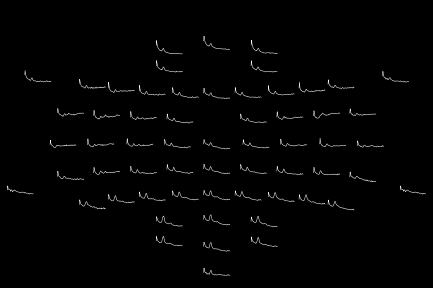

In [55]:
# open dataset
ds = xr.open_dataset('data/eegdata.nc')
# create mne object from dataset
sub = 0
task = 'baseline'
ch_names = list(ds.coords['channel'].values)
info = mne.create_info(ch_names=ch_names, sfreq=1000, ch_types='eeg')

data = ds[task][sub].to_numpy()
bads = ast.literal_eval(ds.attrs['bad_channels'][sub])
info['bads'] = bads
raw_ds = mne.io.RawArray(data, info)
raw_ds.set_channel_types({'ECG':'ecg'})

# raw.add_reference_channels(ref_channels = 'FCz') # is it for adding the reference channel to the data?
raw_ds.set_eeg_reference(ref_channels=['M1','M2'])
pos = make_montage()
raw_ds.set_montage(pos)
raw_ds. plot_psd_topo(fmin=0, fmax=40)
plt.show()  

### Bad channels detections
As it was explained in the "topographical map" video, here we want to use topographical maps to validate the detected bad channels. (this is only for deciding on the channels that I was not sure if I should mark them as bad or not)
Rightfully detecting bad channels is very important, because this will affect re-referencig and autoreject threshold. 
to-do: 1.we can use Shamlo's algorithm for detecting bad channels. 2.set a colorbad with specific vmin and vmax.

Extracting parameters from data/Main-study/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 333580  =      0.000 ...   333.580 secs...
Reading events from data/Main-study/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_events.tsv.
Reading channel info from data/Main-study/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_channels.tsv.


/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_14852/3300187974.py:12: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(path, verbose=False, misc=['ECG'])
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_14852/3300187974.py:13: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  raw.set_channel_types({'ECG':'ecg'})
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_14852/2664024009.py:16: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(pos)
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_14852/2664024009.py:16: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['EOG1', 'EOG2']
Consider setti

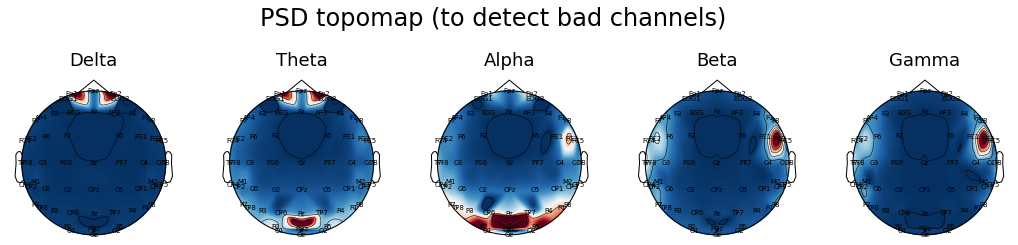

In [28]:
# open and test raw data for each subject at different tasks
subject='01'
session = '01'
task = 'baseline1'
bids_root = Path('data/Main-study')
if not bids_root.exists():
    raise Exception(f'{bids_root} not found!')

bids_path = mne_bids.BIDSPath(subject=subject, session=session, task=task, root=bids_root)
raw = mne_bids.read_raw_bids(bids_path, extra_params={'preload':True}, verbose=False)
raw.set_channel_types({'ECG':'ecg'})

# Set montage
pos = make_montage() # making montage from data position is almost the same as using BC-128.bvef
                     # only difference is that bvef does not include mastoid channels' names
raw.set_montage(pos)
pos = raw.get_montage() # because of eog channels, we should re-get the digitized point after we set the new montage

# pos is an object of DigMontage type, instead we need a 2D array of XY channel postions,
# the following will do that
ch_pos = np.array(list(pos.get_positions()['ch_pos'].values())) 
ch_pos = ch_pos[:,0:2]

# creat a dictionary of the frequency bands with their lower and upper bounds
keys = ['Delta','Theta', 'Alpha', 'Beta', 'Gamma']
bounds = [(0,4), (4,8), (8,12), (12,30), (30,45)]
bands = dict(zip(keys, bounds))

# psd topomap across different frequency bands
fig, axes = plt.subplots(1, len(bands), sharex= True, figsize=(18,3.5))
for i,key in enumerate(bands.keys()):
    psds = mne.time_frequency.psd_welch(raw, fmin=bands[key][0], fmax=bands[key][1], picks=['eeg'], average= 'mean', verbose=False)
    psds_mean = psds[0].mean(axis=1)
    mne.viz.plot_topomap(psds_mean, ch_pos, cmap='RdBu_r', axes=axes[i], outlines='head', show_names=True, names=raw.ch_names, show=False)
    axes[i].set_title(key, fontsize=18)

plt.suptitle('PSD topomap (to detect bad channels)', y=1.12, fontsize=24)
plt.show()

In [110]:
prep.noisy_channels_original

{'bad_by_nan': [],
 'bad_by_flat': [],
 'bad_by_deviation': ['FC6'],
 'bad_by_hf_noise': [],
 'bad_by_correlation': ['T7', 'T8', 'P8', 'FC5', 'FC6', 'FT7'],
 'bad_by_SNR': [],
 'bad_by_dropout': [],
 'bad_by_ransac': ['FT8', 'C5'],
 'bad_all': ['FT8', 'T7', 'P8', 'FC5', 'C5', 'T8', 'FT7', 'FC6']}

In [14]:
prep.noisy_channels_original

{'bad_by_nan': [],
 'bad_by_flat': [],
 'bad_by_deviation': [],
 'bad_by_hf_noise': [],
 'bad_by_correlation': ['FC5', 'FC6', 'C5', 'C6'],
 'bad_by_SNR': [],
 'bad_by_dropout': [],
 'bad_by_ransac': [],
 'bad_all': ['FC6', 'FC5', 'C6', 'C5']}

In [15]:
from pyprep.find_noisy_channels import NoisyChannels
noisy = NoisyChannels(raw)
bads = noisy.find_all_bads()
print(bads)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)

found raw._data
Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!
None


In [ ]:
subject='01'
session = '01'
# tasks = [ 
#     'induction1', 'experience1', 
#     'induction2', 'experience2',
#     'induction3', 'experience3',
#     'induction4', 'experience4',
#     'baseline2'
# ]
tasks = ['induction1']

bids_root = Path('data/Main-study')

# open baseline1
bids_path = mne_bids.BIDSPath(subject=subject, session=session, task='baseline1', root=bids_root)
raw = mne_bids.read_raw_bids(bids_path, verbose=False)

for task in tasks:
    bids_path = mne_bids.BIDSPath(subject=subject, session=session, task=task, root=bids_root)
    raw_temp = mne_bids.read_raw_bids(bids_path, verbose=False)
    raw.append(raw_temp)


# set montage
pos = make_montage()
raw.set_montage(pos)
pos = raw.get_montage()

prep_params = {
    "ref_chs":"eeg",
    "reref_chs":"eeg",
    "line_freqs":np.arange(50, 1000 / 2, 50),
}

# prep = PrepPipeline(raw, prep_params, pos)
# prep.fit()



In [ ]:
# TODO create a function that find bad channels based on impedance, and shamlo's algorithm

# low impedance finder

# channels deviations from the norm using pyprep

# robus reference

### highpass filter cutoff
in the second iteration of preprocessing the cutoff of highpass filtering will be changed to 0.5. Different value of cutoffs (None, 0.3, 0.5, 1) applied to the baseline1 part of subject 01's eeg data. From the visulisation cutoff 1 could eliminate the majority of drift artefacts. If we don't want to go for a highpass as large as 1, the cutoff value of 0.5 was slightly better than 0.3, so we will choose 0.5Hz. Also, this is the value suggested by Mike X. cohen in his video about the preprocessing steps.

to-do: lowpass filtering and its parameters.

### AutoReject
In this part, I'll apply autoreject (global) and will compare the result with the manual rejection. 

In [ ]:
subject='01'
session = '01'
task = 'baseline1'
bids_root = '/Users/yeganeh/Codes/otka-preprocessing/data/Main-study'
bids_path = mne_bids.BIDSPath(subject=subject, session=session, task=task, root=bids_root)
sampling_freq = 1000

raw = mne_bids.read_raw_bids(bids_path, extra_params={'preload':True}, verbose=False)
# raw.drop_channels(['FC6'])

raw.set_eeg_reference(['M1','M2'])
raw.filter(0.5,40)
raw = cut_noisy(raw, task=task, language='hun')
pos = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(pos)

new_annot = mne.Annotations(onset=[0],
                         duration=[int(len(raw)/sampling_freq)],
                        description=['baseline1'])
raw.set_annotations(new_annot)
events, event_dict = mne.events_from_annotations(raw, chunk_duration= 1)
## epoch data
epoch = mne.Epochs(raw, events, event_dict, baseline=None, preload= True)

# global rejection treshold

# reject = get_rejection_threshold(epoch, decim=2)

# print('The rejection dictionary is %s' % reject)

# epoch.drop_bad(reject=reject)
# epoch.average().plot()

# local rejection 
ar = AutoReject()
epochs_clean = ar.fit_transform(epoch)


In [152]:
subject='01'
session = '01'
task = 'baseline1'
bids_root = '/Users/yeganeh/Codes/otka-preprocessing/data/Main-study'
bids_path = mne_bids.BIDSPath(subject=subject, session=session, task=task, root=bids_root)
sampling_freq = 1000

raw = mne_bids.read_raw_bids(bids_path, extra_params={'preload':True}, verbose=False)
# raw.drop_channels(['FC6'])

raw.set_eeg_reference(['M1','M2'])
raw.filter(0.5,40)
raw = cut_noisy(raw, task=task, language='hun')
pos = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(pos)

new_annot = mne.Annotations(onset=[0],
                         duration=[int(len(raw)/sampling_freq)],
                        description=['baseline1'])
raw.set_annotations(new_annot)
events, event_dict = mne.events_from_annotations(raw, chunk_duration= 1)
## epoch data
epoch = mne.Epochs(raw, events, event_dict, baseline=None, preload= True)

# global rejection treshold

reject = get_rejection_threshold(epoch, decim=2)

# print('The rejection dictionary is %s' % reject)

epoch.drop_bad(reject=reject)
# epoch.average().plot()

# local rejection 
# ar = AutoReject()
# epochs_clean = ar.fit_transform(epoch)


Extracting parameters from /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 333580  =      0.000 ...   333.580 secs...
Reading events from /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_events.tsv.
Reading channel info from /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_channels.tsv.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency

Number of events,286
Events,baseline1: 286
Time range,-0.200 – 0.500 sec
Baseline,off


### EOG artefact detections
After deleting the bad parts, according to the lenght of the audio recording, first apply a highpass filter of 1 hz, then detect eog events, because it might detect small drift as eog events.
(based on this part, we won't need ICA to remove eog or ecg artefacts)

Using EOG channels: EOG1, EOG2
EOG channel index for this subject is: [26 27]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 500 significant peaks
Number of EOG events detected: 500
Not setting metadata
Not setting metadata
500 matching events found
Applying baseline correction (mode: mean)
Loading data for 500 events and 1001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata

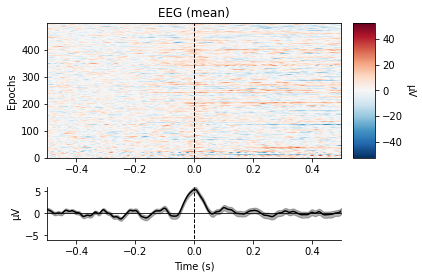

<Figure size 432x288 with 0 Axes>

In [156]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2))
eog_epochs.plot_image(combine='mean')
plt.savefig('eogevents.png')
plt.show()

Extracting parameters from /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/sub-01/ses-01/eeg/sub-01_ses-01_task-experience1_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 416388  =      0.000 ...   416.388 secs...
Reading events from /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/sub-01/ses-01/eeg/sub-01_ses-01_task-experience1_events.tsv.
Reading channel info from /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/sub-01/ses-01/eeg/sub-01_ses-01_task-experience1_channels.tsv.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth:

/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_15578/3345878514.py:30: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(path, verbose=False, misc=['ECG'])
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_15578/3345878514.py:31: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  raw.set_channel_types({'ECG':'ecg'})
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_15578/2405356396.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(pos)


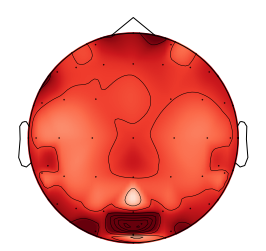

(<matplotlib.image.AxesImage at 0x7fe9f130b850>,
 <matplotlib.contour.QuadContourSet at 0x7fe9f130bb20>)